## Active learning

<img src="./Perception_4_ActiveLearning_7_OnlineLearning.png" alt="Drawing" style="width: 800px;"/>

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import visualize
from utils import pickle_load
from utils import pickle_save
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
# segmentation models wrapper
from segmodel import SegModel
from segmodel import model_selection_function
# anomaly detection functions
from anomaly_detection import sample_selection_function

### Load data

In [2]:
DATA_DIR = './data/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# all data paths
X_train_paths = np.array([os.path.join(x_train_dir, image_name) for image_name in os.listdir(x_train_dir)])
y_train_paths = np.array([os.path.join(y_train_dir, image_name) for image_name in os.listdir(y_train_dir)])

X_valid_paths = np.array([os.path.join(x_valid_dir, image_name) for image_name in os.listdir(x_valid_dir)])
y_valid_paths = np.array([os.path.join(y_valid_dir, image_name) for image_name in os.listdir(y_valid_dir)])

X_test_paths = np.array([os.path.join(x_test_dir, image_name) for image_name in os.listdir(x_test_dir)])
y_test_paths = np.array([os.path.join(y_test_dir, image_name) for image_name in os.listdir(y_test_dir)])

### Active Learning experiment

- X_train, y_train: is used partially to train a model
- X_valid, y_valid: is used fully for validation
- X_test, y_test: is used as an unlabelled set to detect anomalies and add labels to train set

#### Main AL experiment

In [3]:
def al_experiment(model_str, samples_selection_fn, k, experiment_name, visualize_most_uncertain=False, verbose_train=False):
    
    tb = SummaryWriter(log_dir=f'al_runs/{experiment_name}')
    
    # define model from its name
    model = model_selection_function(model_str)
    model.epochs = MODEL_TRAIN_EPOCHS
    # define samples selection function from its name
    samples_selection_fn = sample_selection_function(samples_selection_str)

    # select k random samples from initial dataset and treat it as initially labelled data
    X = np.copy(X_train_paths)
    y = np.copy(y_train_paths)
    selection = np.random.choice(len(X), INITIAL_N_TRAIN_IMAGES, replace=False) # k
    X_train_paths_part = X[selection]
    y_train_paths_part = y[selection]

    X_test = np.copy(X_test_paths)
    y_test = np.copy(y_test_paths)

    IoUs = [0.]
    N_train_samples = [0]
    
    # main loop
    while len(X_train_paths_part) <= MAX_QUEERY_IMAGES:
        # train model
        print('Labelled set size: ', len(X_train_paths_part))
        print('Unlabelled set size: ', len(X_test))
        print(f'\nTraining a model for {MODEL_TRAIN_EPOCHS} epochs...')
        model.train(X_train_paths_part, y_train_paths_part, X_valid_paths, y_valid_paths, verbose=verbose_train)

        # remeber results
        print(f'IoU so far: {model.max_iou_score}')
        IoUs.append(model.max_iou_score)
        N_train_samples.append(len(X_train_paths_part))
        
        tb.add_scalar('IoU vs N_train', model.max_iou_score, len(X_train_paths_part))
        
        if len(X_test) < k:
            print('\nNo more images in Unlabelled set')
            break
            
        selected_images_indexes = samples_selection_fn(X_test, k, model)

        # Add labels for uncertain images to train data
        #print('Labelled set before: ', len(X_train_paths_part))
        X_train_paths_part = np.concatenate([X_train_paths_part, X_test_paths[selected_images_indexes]])
        y_train_paths_part = np.concatenate([y_train_paths_part, y_test_paths[selected_images_indexes]])
        #print('Labelled set after: ', len(X_train_paths_part))

        # Visualization
        if visualize_most_uncertain:
            print('Visualizing most uncertain results so far:')
            for i in selected_images_indexes[:1]:
                img_path = X_test[i]
                image = cv2.imread(img_path)[...,(2,1,0)]
                gt_mask = cv2.imread(y_test_paths[i])
                pr_mask = model.predict([img_path])
                mask_np = pr_mask.squeeze().cpu().numpy().round()

                visualize(image=image, car_mask=mask_np[0,...], road_mask=mask_np[1,...])

        # Remove labelled data from validation set
        #print('Unlabelled set before: ', len(X_test))
        X_test = np.delete(X_test, selected_images_indexes)
        y_test = np.delete(y_test, selected_images_indexes)
        #print('Unlabelled set after: ', len(X_test))
        
    print(f'Max IoU score: {np.max(IoUs)}')
    print('----------------------------------------\n')
    return IoUs, N_train_samples

In [4]:
MAX_QUEERY_IMAGES = 220 # 220 # maximum number of images to train on during AL loop
MODEL_TRAIN_EPOCHS = 1 # 5 # number of epochs to train a model during one AL cicle
INITIAL_N_TRAIN_IMAGES = 20 # 20, initial number of accessible labelled images
NUM_UNCERTAIN_IMAGES = [10, 20, 40, 60] # k: number of uncertain images to label at each AL cicle
SAMPLES_SELECTIONS = ['Random', 'Margin', 'Entropy']
MODELS = ['Unet', 'Linknet']#, 'FPN', 'PSPNet']

In [5]:
name = ''
for model in MODELS:
    name += model + '_'
name += 'Nsamples_'+str(MAX_QUEERY_IMAGES)
name += '_epochs_'+str(MODEL_TRAIN_EPOCHS)
name += '_N0_'+str(INITIAL_N_TRAIN_IMAGES)
name += '_Ks_'
for k in NUM_UNCERTAIN_IMAGES:
    name += str(k) + '_'
for fn in SAMPLES_SELECTIONS:
    name += fn + '_'
RESULTS_FNAME = name+'.pkl'
print(RESULTS_FNAME)

Unet_Linknet_Nsamples_220_epochs_1_N0_20_Ks_10_20_40_60_Random_Margin_Entropy_.pkl


In [6]:
results = {}

# choose model
for model_str in MODELS:
    print(f'\nModel name: {model_str}')
    print('------------------------------------')
    results[model_str] = {}
    
    # choose samples selection function
    for samples_selection_str in SAMPLES_SELECTIONS:
        print(f'\nSamples selection function: {samples_selection_str}')
        print('------------------------------------')
        results[model_str][samples_selection_str] = {}
        
        # choose number of samples to select for labelling from inference results
        for k in NUM_UNCERTAIN_IMAGES:
            print(f'\nNumber of samples to label on one iteration, k={k}')
            print('------------------------------------')
            results[model_str][samples_selection_str][str(k)] = {}
            
            NAME = f'{model_str}-{samples_selection_str}-{k}'
            IoUs, N_train_samples = al_experiment(model_str, samples_selection_str, k, NAME, verbose_train=False)
            
            results[model_str][samples_selection_str][str(k)]['IoUs'] = IoUs
            results[model_str][samples_selection_str][str(k)]['N_train_samples'] = N_train_samples
            
pickle_save('results/'+RESULTS_FNAME, results)


Model name: Unet
------------------------------------

Samples selection function: Random
------------------------------------

Number of samples to label on one iteration, k=10
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...
IoU so far: 3.382655131804258e-06
Labelled set size:  30
Unlabelled set size:  223

Training a model for 1 epochs...
IoU so far: 0.003944182859366297
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...
IoU so far: 0.1117507955889301
Labelled set size:  50
Unlabelled set size:  203

Training a model for 1 epochs...
IoU so far: 0.22953363308812133
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...
IoU so far: 0.3740680937719818
Labelled set size:  70
Unlabelled set size:  183

Training a model for 1 epochs...
IoU so far: 0.3871026478781557
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...
IoU so far:

  1%|          | 2/233 [00:00<00:15, 15.30it/s]

IoU so far: 3.222983943809134e-07
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 14.83it/s]

Min margin: 5.21,             Mean margin: 5.34,             Max margin: 5.57
Labelled set size:  30
Unlabelled set size:  223

Training a model for 1 epochs...



  1%|          | 2/223 [00:00<00:14, 14.79it/s]

IoU so far: 0.003297929922386283
Inference on unlabelled data...


100%|██████████| 223/223 [00:15<00:00, 14.35it/s]

Min margin: 5.20,             Mean margin: 5.36,             Max margin: 5.58
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:13, 15.59it/s]

IoU so far: 0.11586950549689852
Inference on unlabelled data...


100%|██████████| 213/213 [00:14<00:00, 14.90it/s]

Min margin: 3.18,             Mean margin: 4.67,             Max margin: 5.34
Labelled set size:  50
Unlabelled set size:  203

Training a model for 1 epochs...



  1%|          | 2/203 [00:00<00:12, 16.40it/s]

IoU so far: 0.280025576600934
Inference on unlabelled data...


100%|██████████| 203/203 [00:13<00:00, 15.00it/s]

Min margin: 2.35,             Mean margin: 4.12,             Max margin: 5.19
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:10, 18.21it/s]

IoU so far: 0.35684881883092445
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.47it/s]

Min margin: 1.93,             Mean margin: 3.42,             Max margin: 4.92
Labelled set size:  70
Unlabelled set size:  183

Training a model for 1 epochs...



  1%|          | 2/183 [00:00<00:09, 18.39it/s]

IoU so far: 0.3680381515238546
Inference on unlabelled data...


100%|██████████| 183/183 [00:11<00:00, 15.43it/s]

Min margin: 2.27,             Mean margin: 3.33,             Max margin: 4.62
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:13, 12.39it/s]

IoU so far: 0.46404532778381125
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 15.83it/s]

Min margin: 2.30,             Mean margin: 2.80,             Max margin: 3.73
Labelled set size:  90
Unlabelled set size:  163

Training a model for 1 epochs...



  1%|          | 2/163 [00:00<00:09, 17.54it/s]

IoU so far: 0.46409501740247905
Inference on unlabelled data...


100%|██████████| 163/163 [00:10<00:00, 15.39it/s]

Min margin: 2.39,             Mean margin: 2.78,             Max margin: 3.77
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 18.10it/s]

IoU so far: 0.5569840389313082
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 16.83it/s]

Min margin: 2.24,             Mean margin: 2.63,             Max margin: 3.45
Labelled set size:  110
Unlabelled set size:  143

Training a model for 1 epochs...



  1%|▏         | 2/143 [00:00<00:08, 16.52it/s]

IoU so far: 0.563771357040594
Inference on unlabelled data...


100%|██████████| 143/143 [00:08<00:00, 16.88it/s]

Min margin: 1.93,             Mean margin: 2.33,             Max margin: 3.11
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:07, 18.70it/s]

IoU so far: 0.5998405029277989
Inference on unlabelled data...


100%|██████████| 133/133 [00:07<00:00, 17.09it/s]

Min margin: 1.76,             Mean margin: 2.06,             Max margin: 2.72
Labelled set size:  130
Unlabelled set size:  123

Training a model for 1 epochs...



  2%|▏         | 2/123 [00:00<00:06, 18.19it/s]

IoU so far: 0.6526318369525494
Inference on unlabelled data...


100%|██████████| 123/123 [00:06<00:00, 17.77it/s]

Min margin: 1.56,             Mean margin: 1.86,             Max margin: 2.41
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:05, 18.50it/s]

IoU so far: 0.6784937499773385
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 16.86it/s]

Min margin: 1.45,             Mean margin: 1.70,             Max margin: 2.15
Labelled set size:  150
Unlabelled set size:  103

Training a model for 1 epochs...



  2%|▏         | 2/103 [00:00<00:05, 17.62it/s]

IoU so far: 0.6699927313493031
Inference on unlabelled data...


100%|██████████| 103/103 [00:05<00:00, 17.73it/s]

Min margin: 1.33,             Mean margin: 1.51,             Max margin: 1.95
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:04, 18.71it/s]

IoU so far: 0.717178915396775
Inference on unlabelled data...


100%|██████████| 93/93 [00:05<00:00, 16.91it/s]

Min margin: 1.20,             Mean margin: 1.37,             Max margin: 1.70
Labelled set size:  170
Unlabelled set size:  83

Training a model for 1 epochs...



  2%|▏         | 2/83 [00:00<00:04, 18.01it/s]

IoU so far: 0.739278063325599
Inference on unlabelled data...


100%|██████████| 83/83 [00:04<00:00, 17.57it/s]

Min margin: 1.04,             Mean margin: 1.23,             Max margin: 1.69
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:03, 18.62it/s]

IoU so far: 0.7496295771976509
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 16.74it/s]

Min margin: 0.96,             Mean margin: 1.11,             Max margin: 1.42
Labelled set size:  190
Unlabelled set size:  63

Training a model for 1 epochs...



  3%|▎         | 2/63 [00:00<00:04, 12.81it/s]

IoU so far: 0.7468452430007482
Inference on unlabelled data...


100%|██████████| 63/63 [00:04<00:00, 14.99it/s]

Min margin: 0.85,             Mean margin: 0.97,             Max margin: 1.23
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:02, 18.26it/s]

IoU so far: 0.7714782109354981
Inference on unlabelled data...


100%|██████████| 53/53 [00:03<00:00, 16.92it/s]

Min margin: 0.74,             Mean margin: 0.90,             Max margin: 1.13
Labelled set size:  210
Unlabelled set size:  43

Training a model for 1 epochs...



  5%|▍         | 2/43 [00:00<00:02, 18.44it/s]

IoU so far: 0.7828194622946262
Inference on unlabelled data...


100%|██████████| 43/43 [00:02<00:00, 18.16it/s]

Min margin: 0.58,             Mean margin: 0.75,             Max margin: 0.91
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 17.17it/s]

IoU so far: 0.7859355689275384
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 17.18it/s]


Min margin: 0.49,             Mean margin: 0.60,             Max margin: 0.72
Max IoU score: 0.7859355689275384
----------------------------------------


Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:14, 16.00it/s]

IoU so far: 4.286561454746071e-05
Inference on unlabelled data...


100%|██████████| 233/233 [00:14<00:00, 15.83it/s]

Min margin: 5.34,             Mean margin: 5.45,             Max margin: 5.60
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 16.46it/s]

IoU so far: 0.0007885609134577505
Inference on unlabelled data...


100%|██████████| 213/213 [00:14<00:00, 14.48it/s]

Min margin: 5.14,             Mean margin: 5.34,             Max margin: 5.55
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:11, 17.18it/s]

IoU so far: 0.007462253769050168
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 14.90it/s]


Min margin: 3.74,             Mean margin: 4.50,             Max margin: 5.01
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...


  1%|          | 2/173 [00:00<00:10, 16.16it/s]

IoU so far: 0.08312192230974094
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 16.24it/s]

Min margin: 2.36,             Mean margin: 3.86,             Max margin: 4.61
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 18.78it/s]

IoU so far: 0.18294994105206855
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 15.31it/s]

Min margin: 2.63,             Mean margin: 3.37,             Max margin: 4.18
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:06, 19.05it/s]

IoU so far: 0.2521394731679766
Inference on unlabelled data...


100%|██████████| 133/133 [00:07<00:00, 18.10it/s]

Min margin: 2.47,             Mean margin: 3.04,             Max margin: 4.07
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 17.89it/s]

IoU so far: 0.4146824307961039
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 17.09it/s]

Min margin: 2.50,             Mean margin: 2.97,             Max margin: 3.88
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:04, 18.30it/s]

IoU so far: 0.5111111328743475
Inference on unlabelled data...


100%|██████████| 93/93 [00:05<00:00, 18.04it/s]

Min margin: 2.15,             Mean margin: 2.66,             Max margin: 3.49
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:05, 13.53it/s]

IoU so far: 0.5516904672183611
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 14.89it/s]

Min margin: 1.84,             Mean margin: 2.29,             Max margin: 3.11
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:02, 19.32it/s]

IoU so far: 0.5610723123692047
Inference on unlabelled data...


100%|██████████| 53/53 [00:02<00:00, 19.20it/s]

Min margin: 1.67,             Mean margin: 2.07,             Max margin: 2.76
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 17.31it/s]

IoU so far: 0.5544074936078327
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 18.00it/s]


Min margin: 1.63,             Mean margin: 1.93,             Max margin: 2.36
Max IoU score: 0.5610723123692047
----------------------------------------


Number of samples to label on one iteration, k=40
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

IoU so far: 2.304725289875539e-06
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.24it/s]

Min margin: 5.25,             Mean margin: 5.39,             Max margin: 5.57
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:10, 17.40it/s]

IoU so far: 0.03757243255489866
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.73it/s]

Min margin: 3.97,             Mean margin: 5.04,             Max margin: 5.54
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 17.48it/s]

IoU so far: 0.2821583322959372
Inference on unlabelled data...


100%|██████████| 153/153 [00:10<00:00, 15.09it/s]

Min margin: 2.49,             Mean margin: 3.58,             Max margin: 5.24
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 16.22it/s]

IoU so far: 0.32917536131226205
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 17.71it/s]

Min margin: 2.68,             Mean margin: 3.26,             Max margin: 4.94
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:03, 17.96it/s]

IoU so far: 0.4163076408428721
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 16.78it/s]

Min margin: 2.83,             Mean margin: 3.23,             Max margin: 4.78
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...


IoU so far: 0.5098732113838196

No more images in Unlabelled set
Max IoU score: 0.5098732113838196
----------------------------------------


Number of samples to label on one iteration, k=60
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:14, 15.42it/s]

IoU so far: 8.998302807183874e-05
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 14.63it/s]

Min margin: 5.15,             Mean margin: 5.41,             Max margin: 5.58
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:10, 15.83it/s]

IoU so far: 0.13434293371911094
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 15.74it/s]

Min margin: 2.27,             Mean margin: 4.16,             Max margin: 5.47
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 16.64it/s]

IoU so far: 0.3302513611788797
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 15.72it/s]

Min margin: 1.93,             Mean margin: 3.43,             Max margin: 5.03
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...


IoU so far: 0.4096350542979665

No more images in Unlabelled set
Max IoU score: 0.4096350542979665
----------------------------------------


Samples selection function: Entropy
------------------------------------

Number of samples to label on one iteration, k=10
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:13, 17.18it/s]

IoU so far: 6.994630227585955e-05
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.20it/s]

Min entropy: 5.25,             Mean Entropy: 5.48,             Max entropy: 5.66
Labelled set size:  30
Unlabelled set size:  223

Training a model for 1 epochs...



  1%|          | 2/223 [00:00<00:13, 16.76it/s]

IoU so far: 0.00016012460615676594
Inference on unlabelled data...


100%|██████████| 223/223 [00:15<00:00, 14.86it/s]

Min entropy: 5.01,             Mean Entropy: 5.43,             Max entropy: 5.56
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 17.06it/s]

IoU so far: 0.050438809586633535
Inference on unlabelled data...


100%|██████████| 213/213 [00:13<00:00, 15.28it/s]

Min entropy: 3.32,             Mean Entropy: 5.10,             Max entropy: 5.49
Labelled set size:  50
Unlabelled set size:  203

Training a model for 1 epochs...



  1%|          | 2/203 [00:00<00:11, 18.09it/s]

IoU so far: 0.07818947621796393
Inference on unlabelled data...


100%|██████████| 203/203 [00:11<00:00, 17.34it/s]

Min entropy: 2.26,             Mean Entropy: 4.16,             Max entropy: 5.42
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:10, 18.23it/s]

IoU so far: 0.0958978009253445
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.77it/s]

Min entropy: 2.10,             Mean Entropy: 3.78,             Max entropy: 5.18
Labelled set size:  70
Unlabelled set size:  183

Training a model for 1 epochs...



  1%|          | 2/183 [00:00<00:09, 18.86it/s]

IoU so far: 0.17896729574935277
Inference on unlabelled data...


100%|██████████| 183/183 [00:11<00:00, 15.93it/s]

Min entropy: 2.22,             Mean Entropy: 4.02,             Max entropy: 5.11
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:08, 19.85it/s]

IoU so far: 0.2004988317442412
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 16.78it/s]

Min entropy: 2.08,             Mean Entropy: 3.75,             Max entropy: 4.91
Labelled set size:  90
Unlabelled set size:  163

Training a model for 1 epochs...



  1%|          | 2/163 [00:00<00:08, 18.99it/s]

IoU so far: 0.22681820923739143
Inference on unlabelled data...


100%|██████████| 163/163 [00:10<00:00, 16.13it/s]

Min entropy: 2.13,             Mean Entropy: 3.48,             Max entropy: 4.80
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:07, 19.43it/s]

IoU so far: 0.23866665392819014
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 16.03it/s]

Min entropy: 2.04,             Mean Entropy: 3.17,             Max entropy: 4.43
Labelled set size:  110
Unlabelled set size:  143

Training a model for 1 epochs...



  1%|▏         | 2/143 [00:00<00:07, 19.78it/s]

IoU so far: 0.41730115850373073
Inference on unlabelled data...


100%|██████████| 143/143 [00:08<00:00, 15.89it/s]

Min entropy: 1.90,             Mean Entropy: 2.73,             Max entropy: 3.55
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:06, 19.84it/s]

IoU so far: 0.4471842705613316
Inference on unlabelled data...


100%|██████████| 133/133 [00:08<00:00, 16.30it/s]

Min entropy: 1.68,             Mean Entropy: 2.33,             Max entropy: 3.10
Labelled set size:  130
Unlabelled set size:  123

Training a model for 1 epochs...



  2%|▏         | 2/123 [00:00<00:06, 19.11it/s]

IoU so far: 0.48804014832666615
Inference on unlabelled data...


100%|██████████| 123/123 [00:07<00:00, 16.47it/s]

Min entropy: 1.55,             Mean Entropy: 2.22,             Max entropy: 2.83
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 18.48it/s]

IoU so far: 0.49631688647931166
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 16.97it/s]

Min entropy: 1.43,             Mean Entropy: 1.94,             Max entropy: 2.58
Labelled set size:  150
Unlabelled set size:  103

Training a model for 1 epochs...



  2%|▏         | 2/103 [00:00<00:05, 19.43it/s]

IoU so far: 0.5174184887125941
Inference on unlabelled data...


100%|██████████| 103/103 [00:05<00:00, 18.56it/s]

Min entropy: 1.26,             Mean Entropy: 1.69,             Max entropy: 2.06
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:04, 19.44it/s]

IoU so far: 0.5196969054713111
Inference on unlabelled data...


100%|██████████| 93/93 [00:05<00:00, 17.36it/s]

Min entropy: 1.17,             Mean Entropy: 1.55,             Max entropy: 1.90
Labelled set size:  170
Unlabelled set size:  83

Training a model for 1 epochs...



  2%|▏         | 2/83 [00:00<00:06, 13.25it/s]

IoU so far: 0.5144777159289557
Inference on unlabelled data...


100%|██████████| 83/83 [00:05<00:00, 16.24it/s]

Min entropy: 1.00,             Mean Entropy: 1.33,             Max entropy: 1.71
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 17.68it/s]

IoU so far: 0.5270985356061766
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 17.34it/s]

Min entropy: 0.93,             Mean Entropy: 1.20,             Max entropy: 1.50
Labelled set size:  190
Unlabelled set size:  63

Training a model for 1 epochs...



  3%|▎         | 2/63 [00:00<00:03, 18.74it/s]

IoU so far: 0.5803580930327422
Inference on unlabelled data...


100%|██████████| 63/63 [00:03<00:00, 18.49it/s]

Min entropy: 0.80,             Mean Entropy: 1.05,             Max entropy: 1.27
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:02, 18.32it/s]

IoU so far: 0.6881398847787686
Inference on unlabelled data...


100%|██████████| 53/53 [00:03<00:00, 17.58it/s]

Min entropy: 0.74,             Mean Entropy: 0.97,             Max entropy: 1.19
Labelled set size:  210
Unlabelled set size:  43

Training a model for 1 epochs...



  5%|▍         | 2/43 [00:00<00:02, 19.09it/s]

IoU so far: 0.7286685593057386
Inference on unlabelled data...


100%|██████████| 43/43 [00:02<00:00, 18.78it/s]

Min entropy: 0.73,             Mean Entropy: 0.95,             Max entropy: 1.11
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 17.75it/s]

IoU so far: 0.7306915167534704
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 17.70it/s]


Min entropy: 0.56,             Mean Entropy: 0.74,             Max entropy: 0.86
Max IoU score: 0.7306915167534704
----------------------------------------


Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:14, 16.39it/s]

IoU so far: 5.425345674467919e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:14<00:00, 15.60it/s]

Min entropy: 5.23,             Mean Entropy: 5.32,             Max entropy: 5.44
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 16.63it/s]

IoU so far: 0.0004058003284602191
Inference on unlabelled data...


100%|██████████| 213/213 [00:14<00:00, 14.47it/s]

Min entropy: 4.96,             Mean Entropy: 5.36,             Max entropy: 5.58
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:10, 18.19it/s]

IoU so far: 0.37647013439990507
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.87it/s]

Min entropy: 1.62,             Mean Entropy: 2.92,             Max entropy: 5.15
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:10, 16.00it/s]

IoU so far: 0.4501589808133568
Inference on unlabelled data...


100%|██████████| 173/173 [00:11<00:00, 15.27it/s]

Min entropy: 1.90,             Mean Entropy: 2.70,             Max entropy: 3.95
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 16.95it/s]

IoU so far: 0.48335596919059737
Inference on unlabelled data...


100%|██████████| 153/153 [00:08<00:00, 17.20it/s]

Min entropy: 2.14,             Mean Entropy: 2.62,             Max entropy: 3.14
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:07, 16.84it/s]

IoU so far: 0.5386328906706067
Inference on unlabelled data...


100%|██████████| 133/133 [00:07<00:00, 17.29it/s]

Min entropy: 2.19,             Mean Entropy: 2.60,             Max entropy: 3.00
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 17.39it/s]

IoU so far: 0.6012771029283502
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 17.77it/s]

Min entropy: 2.01,             Mean Entropy: 2.33,             Max entropy: 2.60
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:05, 16.02it/s]

IoU so far: 0.6360212617581432
Inference on unlabelled data...


100%|██████████| 93/93 [00:05<00:00, 17.82it/s]

Min entropy: 1.68,             Mean Entropy: 1.95,             Max entropy: 2.20
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:03, 18.25it/s]

IoU so far: 0.6632510624309578
Inference on unlabelled data...


100%|██████████| 73/73 [00:03<00:00, 18.25it/s]

Min entropy: 1.50,             Mean Entropy: 1.77,             Max entropy: 1.92
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:04, 12.64it/s]

IoU so far: 0.6857460867060292
Inference on unlabelled data...


100%|██████████| 53/53 [00:03<00:00, 14.55it/s]

Min entropy: 1.26,             Mean Entropy: 1.48,             Max entropy: 1.63
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 18.21it/s]

IoU so far: 0.6833266869629967
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 18.49it/s]


Min entropy: 0.92,             Mean Entropy: 1.07,             Max entropy: 1.18
Max IoU score: 0.6857460867060292
----------------------------------------


Number of samples to label on one iteration, k=40
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  0%|          | 1/233 [00:00<00:24,  9.52it/s]

IoU so far: 1.5037956570131226e-06
Inference on unlabelled data...


100%|██████████| 233/233 [00:16<00:00, 14.43it/s]

Min entropy: 5.22,             Mean Entropy: 5.37,             Max entropy: 5.54
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:11, 16.15it/s]

IoU so far: 0.025499284705423786
Inference on unlabelled data...


100%|██████████| 193/193 [00:11<00:00, 16.12it/s]

Min entropy: 3.73,             Mean Entropy: 5.06,             Max entropy: 5.46
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 18.07it/s]

IoU so far: 0.1689575440665283
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 16.31it/s]

Min entropy: 2.74,             Mean Entropy: 3.40,             Max entropy: 5.03
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 17.46it/s]

IoU so far: 0.4223520018086575
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 16.92it/s]

Min entropy: 2.22,             Mean Entropy: 2.60,             Max entropy: 3.01
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 16.48it/s]

IoU so far: 0.6345110175633193
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 17.08it/s]

Min entropy: 2.01,             Mean Entropy: 2.25,             Max entropy: 2.46
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...


IoU so far: 0.6895553770631847

No more images in Unlabelled set
Max IoU score: 0.6895553770631847
----------------------------------------


Number of samples to label on one iteration, k=60
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:15, 15.19it/s]

IoU so far: 2.701789915986887e-05
Inference on unlabelled data...


100%|██████████| 233/233 [00:14<00:00, 15.57it/s]

Min entropy: 5.19,             Mean Entropy: 5.33,             Max entropy: 5.55
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:14, 12.00it/s]

IoU so far: 0.129863325026956
Inference on unlabelled data...


100%|██████████| 173/173 [00:11<00:00, 15.34it/s]

Min entropy: 2.33,             Mean Entropy: 4.11,             Max entropy: 5.42
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:09, 12.12it/s]

IoU so far: 0.35770352701149355
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 15.31it/s]

Min entropy: 2.07,             Mean Entropy: 2.71,             Max entropy: 4.17
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...


IoU so far: 0.3880877757426538

No more images in Unlabelled set
Max IoU score: 0.3880877757426538
----------------------------------------


Model name: Linknet
------------------------------------

Samples selection function: Random
------------------------------------

Number of samples to label on one iteration, k=10
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...
IoU so far: 5.425347129016378e-13
Labelled set size:  30
Unlabelled set size:  223

Training a model for 1 epochs...
IoU so far: 5.425347129016378e-13
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...
IoU so far: 5.425347129016378e-13
Labelled set size:  50
Unlabelled set size:  203

Training a model for 1 epochs...
IoU so far: 5.425347129016378e-13
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...
IoU so far: 0.0022388936543726533
Labelled set size:  70
Unlabelled set size:  183

Train

  1%|          | 2/233 [00:00<00:14, 16.09it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:13<00:00, 16.67it/s]

Min margin: 4.73,             Mean margin: 4.79,             Max margin: 4.85
Labelled set size:  30
Unlabelled set size:  223

Training a model for 1 epochs...



  1%|          | 2/223 [00:00<00:18, 12.10it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 223/223 [00:14<00:00, 15.87it/s]

Min margin: 4.37,             Mean margin: 4.46,             Max margin: 4.61
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 16.98it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 213/213 [00:13<00:00, 16.09it/s]

Min margin: 4.30,             Mean margin: 4.43,             Max margin: 4.62
Labelled set size:  50
Unlabelled set size:  203

Training a model for 1 epochs...



  1%|          | 2/203 [00:00<00:12, 16.70it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 203/203 [00:11<00:00, 17.00it/s]

Min margin: 4.57,             Mean margin: 4.69,             Max margin: 4.89
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:10, 17.96it/s]

IoU so far: 2.148573296773869e-07
Inference on unlabelled data...


100%|██████████| 193/193 [00:11<00:00, 17.35it/s]

Min margin: 4.87,             Mean margin: 5.09,             Max margin: 5.29
Labelled set size:  70
Unlabelled set size:  183

Training a model for 1 epochs...



  1%|          | 2/183 [00:00<00:10, 17.46it/s]

IoU so far: 0.034010684763145914
Inference on unlabelled data...


100%|██████████| 183/183 [00:12<00:00, 15.20it/s]

Min margin: 4.57,             Mean margin: 5.24,             Max margin: 5.42
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:10, 16.93it/s]

IoU so far: 0.17468648071926424
Inference on unlabelled data...


100%|██████████| 173/173 [00:11<00:00, 14.69it/s]


Min margin: 3.70,             Mean margin: 4.42,             Max margin: 5.38
Labelled set size:  90
Unlabelled set size:  163

Training a model for 1 epochs...


  1%|          | 2/163 [00:00<00:09, 17.42it/s]

IoU so far: 0.19509417364502898
Inference on unlabelled data...


100%|██████████| 163/163 [00:09<00:00, 17.40it/s]

Min margin: 3.53,             Mean margin: 4.41,             Max margin: 5.36
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 16.82it/s]

IoU so far: 0.2409656434366018
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 16.68it/s]

Min margin: 3.13,             Mean margin: 3.82,             Max margin: 4.73
Labelled set size:  110
Unlabelled set size:  143

Training a model for 1 epochs...



  1%|▏         | 2/143 [00:00<00:12, 11.48it/s]

IoU so far: 0.2853275894528568
Inference on unlabelled data...


100%|██████████| 143/143 [00:09<00:00, 15.26it/s]

Min margin: 2.95,             Mean margin: 3.41,             Max margin: 4.20
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:07, 17.52it/s]

IoU so far: 0.3095909236091199
Inference on unlabelled data...


100%|██████████| 133/133 [00:08<00:00, 15.14it/s]

Min margin: 2.91,             Mean margin: 3.34,             Max margin: 3.76
Labelled set size:  130
Unlabelled set size:  123

Training a model for 1 epochs...



  2%|▏         | 2/123 [00:00<00:06, 17.37it/s]

IoU so far: 0.3285019675103745
Inference on unlabelled data...


100%|██████████| 123/123 [00:07<00:00, 17.48it/s]

Min margin: 2.75,             Mean margin: 3.06,             Max margin: 3.45
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 17.66it/s]

IoU so far: 0.3370883190395807
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 17.01it/s]

Min margin: 2.68,             Mean margin: 2.87,             Max margin: 3.43
Labelled set size:  150
Unlabelled set size:  103

Training a model for 1 epochs...



  2%|▏         | 2/103 [00:00<00:08, 12.27it/s]

IoU so far: 0.3394067983816166
Inference on unlabelled data...


100%|██████████| 103/103 [00:06<00:00, 15.38it/s]

Min margin: 2.68,             Mean margin: 2.83,             Max margin: 3.21
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:05, 17.51it/s]

IoU so far: 0.3440803044503279
Inference on unlabelled data...


100%|██████████| 93/93 [00:06<00:00, 14.59it/s]

Min margin: 2.59,             Mean margin: 2.72,             Max margin: 3.03
Labelled set size:  170
Unlabelled set size:  83

Training a model for 1 epochs...



  2%|▏         | 2/83 [00:00<00:04, 17.44it/s]

IoU so far: 0.367713554955945
Inference on unlabelled data...


100%|██████████| 83/83 [00:04<00:00, 17.59it/s]

Min margin: 2.54,             Mean margin: 2.65,             Max margin: 2.85
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 17.18it/s]

IoU so far: 0.3683803057906651
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 17.12it/s]

Min margin: 2.52,             Mean margin: 2.62,             Max margin: 2.89
Labelled set size:  190
Unlabelled set size:  63

Training a model for 1 epochs...



  3%|▎         | 2/63 [00:00<00:03, 16.93it/s]

IoU so far: 0.37101971188394156
Inference on unlabelled data...


100%|██████████| 63/63 [00:03<00:00, 18.40it/s]

Min margin: 2.40,             Mean margin: 2.50,             Max margin: 2.67
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:02, 18.45it/s]

IoU so far: 0.3752150473618271
Inference on unlabelled data...


100%|██████████| 53/53 [00:03<00:00, 17.21it/s]

Min margin: 2.28,             Mean margin: 2.40,             Max margin: 2.64
Labelled set size:  210
Unlabelled set size:  43

Training a model for 1 epochs...



  5%|▍         | 2/43 [00:00<00:02, 17.13it/s]

IoU so far: 0.37684866579452353
Inference on unlabelled data...


100%|██████████| 43/43 [00:02<00:00, 18.34it/s]

Min margin: 2.23,             Mean margin: 2.34,             Max margin: 2.50
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 18.35it/s]

IoU so far: 0.3781771444448149
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 18.84it/s]


Min margin: 2.28,             Mean margin: 2.36,             Max margin: 2.50
Max IoU score: 0.3781771444448149
----------------------------------------


Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:19, 11.70it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.38it/s]

Min margin: 5.08,             Mean margin: 5.13,             Max margin: 5.20
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:12, 16.59it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 213/213 [00:13<00:00, 15.29it/s]

Min margin: 4.98,             Mean margin: 5.03,             Max margin: 5.13
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:11, 17.24it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.05it/s]


Min margin: 5.05,             Mean margin: 5.11,             Max margin: 5.21
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...


  1%|          | 2/173 [00:00<00:11, 14.71it/s]

IoU so far: 4.445974067448188e-05
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 15.91it/s]

Min margin: 4.95,             Mean margin: 5.13,             Max margin: 5.18
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:09, 15.87it/s]

IoU so far: 0.022113150732573306
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 15.47it/s]

Min margin: 4.64,             Mean margin: 5.15,             Max margin: 5.34
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:07, 16.51it/s]

IoU so far: 0.07871941296328412
Inference on unlabelled data...


100%|██████████| 133/133 [00:09<00:00, 14.48it/s]

Min margin: 3.36,             Mean margin: 4.36,             Max margin: 5.32
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 16.08it/s]

IoU so far: 0.13402048033652922
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 14.71it/s]

Min margin: 2.92,             Mean margin: 3.90,             Max margin: 5.27
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:05, 16.85it/s]

IoU so far: 0.14772235314444734
Inference on unlabelled data...


100%|██████████| 93/93 [00:05<00:00, 16.88it/s]

Min margin: 3.26,             Mean margin: 4.13,             Max margin: 5.22
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 16.42it/s]

IoU so far: 0.19149576245558142
Inference on unlabelled data...


100%|██████████| 73/73 [00:05<00:00, 13.18it/s]

Min margin: 2.86,             Mean margin: 3.88,             Max margin: 5.19
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:03, 16.76it/s]

IoU so far: 0.22672417095982209
Inference on unlabelled data...


100%|██████████| 53/53 [00:03<00:00, 17.17it/s]

Min margin: 2.84,             Mean margin: 3.83,             Max margin: 5.13
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 16.93it/s]

IoU so far: 0.24701097769902494
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 17.18it/s]


Min margin: 2.88,             Mean margin: 3.94,             Max margin: 5.11
Max IoU score: 0.24701097769902494
----------------------------------------


Number of samples to label on one iteration, k=40
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:14, 16.41it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.20it/s]

Min margin: 4.64,             Mean margin: 4.76,             Max margin: 4.88
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:11, 17.33it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.37it/s]

Min margin: 4.55,             Mean margin: 4.71,             Max margin: 4.89
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:10, 14.65it/s]

IoU so far: 0.004219092377968652
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 16.35it/s]

Min margin: 4.82,             Mean margin: 4.94,             Max margin: 5.27
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 16.25it/s]

IoU so far: 0.08291514203099923
Inference on unlabelled data...


100%|██████████| 113/113 [00:08<00:00, 13.77it/s]

Min margin: 2.73,             Mean margin: 5.01,             Max margin: 5.37
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 16.49it/s]

IoU so far: 0.09400030196008112
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 16.80it/s]

Min margin: 4.50,             Mean margin: 4.86,             Max margin: 5.18
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...


IoU so far: 0.09485954134771142

No more images in Unlabelled set
Max IoU score: 0.09485954134771142
----------------------------------------


Number of samples to label on one iteration, k=60
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:12, 18.38it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:13<00:00, 17.35it/s]

Min margin: 4.63,             Mean margin: 4.73,             Max margin: 4.81
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:09, 18.07it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 17.24it/s]

Min margin: 4.85,             Mean margin: 4.89,             Max margin: 4.91
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:09, 11.52it/s]

IoU so far: 0.0011649624768553695
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 14.95it/s]

Min margin: 5.03,             Mean margin: 5.12,             Max margin: 5.35
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...


IoU so far: 0.06919663834689867

No more images in Unlabelled set
Max IoU score: 0.06919663834689867
----------------------------------------


Samples selection function: Entropy
------------------------------------

Number of samples to label on one iteration, k=10
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:13, 16.97it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.38it/s]

Min entropy: 4.73,             Mean Entropy: 4.83,             Max entropy: 4.94
Labelled set size:  30
Unlabelled set size:  223

Training a model for 1 epochs...



  1%|          | 2/223 [00:00<00:14, 15.68it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 223/223 [00:13<00:00, 16.35it/s]

Min entropy: 4.51,             Mean Entropy: 4.56,             Max entropy: 4.64
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...



  1%|          | 2/213 [00:00<00:11, 18.05it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 213/213 [00:12<00:00, 17.17it/s]

Min entropy: 4.59,             Mean Entropy: 4.68,             Max entropy: 4.78
Labelled set size:  50
Unlabelled set size:  203

Training a model for 1 epochs...



  1%|          | 2/203 [00:00<00:17, 11.46it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 203/203 [00:12<00:00, 16.22it/s]

Min entropy: 4.76,             Mean Entropy: 4.87,             Max entropy: 4.96
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:17, 11.10it/s]

IoU so far: 2.6256331308181624e-05
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.47it/s]

Min entropy: 5.01,             Mean Entropy: 5.07,             Max entropy: 5.25
Labelled set size:  70
Unlabelled set size:  183

Training a model for 1 epochs...



  1%|          | 2/183 [00:00<00:11, 16.41it/s]

IoU so far: 0.00042297139632432624
Inference on unlabelled data...


100%|██████████| 183/183 [00:10<00:00, 16.74it/s]

Min entropy: 4.93,             Mean Entropy: 5.04,             Max entropy: 5.17
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:09, 17.24it/s]

IoU so far: 0.011639628236615423
Inference on unlabelled data...


100%|██████████| 173/173 [00:11<00:00, 14.90it/s]

Min entropy: 4.20,             Mean Entropy: 4.69,             Max entropy: 4.84
Labelled set size:  90
Unlabelled set size:  163

Training a model for 1 epochs...



  1%|          | 2/163 [00:00<00:09, 17.47it/s]

IoU so far: 0.029612301784281682
Inference on unlabelled data...


100%|██████████| 163/163 [00:09<00:00, 16.90it/s]

Min entropy: 3.87,             Mean Entropy: 4.34,             Max entropy: 4.56
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:12, 12.52it/s]

IoU so far: 0.06123293025216255
Inference on unlabelled data...


100%|██████████| 153/153 [00:10<00:00, 14.83it/s]

Min entropy: 3.52,             Mean Entropy: 4.07,             Max entropy: 4.26
Labelled set size:  110
Unlabelled set size:  143

Training a model for 1 epochs...



  1%|▏         | 2/143 [00:00<00:13, 10.84it/s]

IoU so far: 0.11775628160132037
Inference on unlabelled data...


100%|██████████| 143/143 [00:09<00:00, 14.81it/s]

Min entropy: 3.60,             Mean Entropy: 3.86,             Max entropy: 4.20
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:08, 15.87it/s]

IoU so far: 0.18990560628399988
Inference on unlabelled data...


100%|██████████| 133/133 [00:07<00:00, 16.63it/s]

Min entropy: 3.03,             Mean Entropy: 3.57,             Max entropy: 3.87
Labelled set size:  130
Unlabelled set size:  123

Training a model for 1 epochs...



  2%|▏         | 2/123 [00:00<00:06, 17.89it/s]

IoU so far: 0.2728565119870821
Inference on unlabelled data...


100%|██████████| 123/123 [00:07<00:00, 16.34it/s]


Min entropy: 3.02,             Mean Entropy: 3.47,             Max entropy: 3.75
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...


  2%|▏         | 2/113 [00:00<00:06, 17.13it/s]

IoU so far: 0.3656445588215743
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 14.62it/s]

Min entropy: 2.63,             Mean Entropy: 3.13,             Max entropy: 3.47
Labelled set size:  150
Unlabelled set size:  103

Training a model for 1 epochs...



  2%|▏         | 2/103 [00:00<00:06, 16.40it/s]

IoU so far: 0.4156231679538688
Inference on unlabelled data...


100%|██████████| 103/103 [00:05<00:00, 17.25it/s]

Min entropy: 2.38,             Mean Entropy: 2.84,             Max entropy: 3.14
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:05, 18.16it/s]

IoU so far: 0.4328537016811936
Inference on unlabelled data...


100%|██████████| 93/93 [00:06<00:00, 14.22it/s]

Min entropy: 2.33,             Mean Entropy: 2.75,             Max entropy: 2.97
Labelled set size:  170
Unlabelled set size:  83

Training a model for 1 epochs...



  2%|▏         | 2/83 [00:00<00:04, 17.90it/s]

IoU so far: 0.4694166567065928
Inference on unlabelled data...


100%|██████████| 83/83 [00:04<00:00, 17.85it/s]

Min entropy: 2.15,             Mean Entropy: 2.57,             Max entropy: 2.78
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 17.68it/s]

IoU so far: 0.4713950927304749
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 16.69it/s]


Min entropy: 1.91,             Mean Entropy: 2.31,             Max entropy: 2.51
Labelled set size:  190
Unlabelled set size:  63

Training a model for 1 epochs...


  3%|▎         | 2/63 [00:00<00:03, 16.87it/s]

IoU so far: 0.4794473836917688
Inference on unlabelled data...


100%|██████████| 63/63 [00:03<00:00, 17.70it/s]

Min entropy: 1.84,             Mean Entropy: 2.13,             Max entropy: 2.36
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:03, 16.35it/s]

IoU so far: 0.4959090331403334
Inference on unlabelled data...


100%|██████████| 53/53 [00:03<00:00, 16.41it/s]

Min entropy: 1.69,             Mean Entropy: 1.97,             Max entropy: 2.11
Labelled set size:  210
Unlabelled set size:  43

Training a model for 1 epochs...



  5%|▍         | 2/43 [00:00<00:02, 17.62it/s]

IoU so far: 0.5058017378986475
Inference on unlabelled data...


100%|██████████| 43/43 [00:02<00:00, 17.91it/s]

Min entropy: 1.60,             Mean Entropy: 1.81,             Max entropy: 1.97
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 18.49it/s]

IoU so far: 0.5216709478656842
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 18.69it/s]


Min entropy: 1.42,             Mean Entropy: 1.66,             Max entropy: 1.89
Max IoU score: 0.5216709478656842
----------------------------------------


Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:13, 17.67it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.48it/s]


Min entropy: 5.05,             Mean Entropy: 5.13,             Max entropy: 5.18
Labelled set size:  40
Unlabelled set size:  213

Training a model for 1 epochs...


  1%|          | 2/213 [00:00<00:12, 17.36it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 213/213 [00:13<00:00, 15.91it/s]

Min entropy: 5.04,             Mean Entropy: 5.10,             Max entropy: 5.14
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:12, 15.74it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.63it/s]

Min entropy: 5.20,             Mean Entropy: 5.23,             Max entropy: 5.25
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:11, 15.18it/s]

IoU so far: 5.425338723765874e-13
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 16.41it/s]

Min entropy: 5.13,             Mean Entropy: 5.20,             Max entropy: 5.23
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:09, 16.66it/s]

IoU so far: 0.031232640405397614
Inference on unlabelled data...


100%|██████████| 153/153 [00:09<00:00, 15.84it/s]

Min entropy: 4.68,             Mean Entropy: 4.94,             Max entropy: 5.06
Labelled set size:  120
Unlabelled set size:  133

Training a model for 1 epochs...



  2%|▏         | 2/133 [00:00<00:07, 16.73it/s]

IoU so far: 0.09633839565633547
Inference on unlabelled data...


100%|██████████| 133/133 [00:07<00:00, 16.93it/s]

Min entropy: 3.75,             Mean Entropy: 4.37,             Max entropy: 4.90
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:10, 10.89it/s]

IoU so far: 0.17538394343734975
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]

Min entropy: 3.08,             Mean Entropy: 3.72,             Max entropy: 4.53
Labelled set size:  160
Unlabelled set size:  93

Training a model for 1 epochs...



  2%|▏         | 2/93 [00:00<00:05, 16.03it/s]

IoU so far: 0.22917964523381526
Inference on unlabelled data...


100%|██████████| 93/93 [00:06<00:00, 14.17it/s]

Min entropy: 2.71,             Mean Entropy: 3.15,             Max entropy: 3.76
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 16.96it/s]

IoU so far: 0.2912772356873692
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 17.48it/s]

Min entropy: 2.46,             Mean Entropy: 2.72,             Max entropy: 3.01
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...



  4%|▍         | 2/53 [00:00<00:02, 18.60it/s]

IoU so far: 0.31203092560909773
Inference on unlabelled data...


100%|██████████| 53/53 [00:02<00:00, 18.61it/s]

Min entropy: 2.44,             Mean Entropy: 2.63,             Max entropy: 2.81
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...



  6%|▌         | 2/33 [00:00<00:01, 18.17it/s]

IoU so far: 0.3281488610376226
Inference on unlabelled data...


100%|██████████| 33/33 [00:01<00:00, 18.74it/s]


Min entropy: 2.26,             Mean Entropy: 2.41,             Max entropy: 2.55
Max IoU score: 0.3281488610376226
----------------------------------------


Number of samples to label on one iteration, k=40
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:13, 17.16it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:14<00:00, 15.77it/s]

Min entropy: 4.79,             Mean Entropy: 4.92,             Max entropy: 5.09
Labelled set size:  60
Unlabelled set size:  193

Training a model for 1 epochs...



  1%|          | 2/193 [00:00<00:10, 17.77it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 193/193 [00:12<00:00, 15.73it/s]

Min entropy: 4.36,             Mean Entropy: 4.41,             Max entropy: 4.48
Labelled set size:  100
Unlabelled set size:  153

Training a model for 1 epochs...



  1%|▏         | 2/153 [00:00<00:08, 17.03it/s]

IoU so far: 5.425346259507705e-13
Inference on unlabelled data...


100%|██████████| 153/153 [00:10<00:00, 14.96it/s]

Min entropy: 4.76,             Mean Entropy: 4.87,             Max entropy: 4.98
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:06, 17.28it/s]

IoU so far: 0.004004191400340326
Inference on unlabelled data...


100%|██████████| 113/113 [00:06<00:00, 16.74it/s]

Min entropy: 5.13,             Mean Entropy: 5.30,             Max entropy: 5.49
Labelled set size:  180
Unlabelled set size:  73

Training a model for 1 epochs...



  3%|▎         | 2/73 [00:00<00:04, 17.67it/s]

IoU so far: 0.06302284401389632
Inference on unlabelled data...


100%|██████████| 73/73 [00:04<00:00, 17.22it/s]

Min entropy: 3.50,             Mean Entropy: 4.71,             Max entropy: 5.26
Labelled set size:  220
Unlabelled set size:  33

Training a model for 1 epochs...


IoU so far: 0.17569702738287424

No more images in Unlabelled set
Max IoU score: 0.17569702738287424
----------------------------------------


Number of samples to label on one iteration, k=60
------------------------------------
Labelled set size:  20
Unlabelled set size:  233

Training a model for 1 epochs...


  1%|          | 2/233 [00:00<00:14, 15.67it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 233/233 [00:15<00:00, 15.41it/s]

Min entropy: 4.79,             Mean Entropy: 4.89,             Max entropy: 4.98
Labelled set size:  80
Unlabelled set size:  173

Training a model for 1 epochs...



  1%|          | 2/173 [00:00<00:11, 15.37it/s]

IoU so far: 5.425347129016378e-13
Inference on unlabelled data...


100%|██████████| 173/173 [00:10<00:00, 17.00it/s]

Min entropy: 4.54,             Mean Entropy: 4.60,             Max entropy: 4.73
Labelled set size:  140
Unlabelled set size:  113

Training a model for 1 epochs...



  2%|▏         | 2/113 [00:00<00:07, 15.63it/s]

IoU so far: 0.011732326405547042
Inference on unlabelled data...


100%|██████████| 113/113 [00:07<00:00, 15.37it/s]

Min entropy: 4.96,             Mean Entropy: 5.24,             Max entropy: 5.36
Labelled set size:  200
Unlabelled set size:  53

Training a model for 1 epochs...


IoU so far: 0.06297247827348142

No more images in Unlabelled set
Max IoU score: 0.06297247827348142
----------------------------------------

saved Unet_Linknet_Nsamples_220_epochs_1_N0_20_Ks_10_20_40_60_Random_Margin_Entropy_.pkl /home/ruslan/Desktop/DoEdu/src/active_learning/src ['data', 'anomaly_detection.py', 'weights', 'Unet_Nsamples_120_epochs_1_N0_20_Ks_10_Random_.pkl', 'augmentations.py', 'segmodel.py', 'utils.py', 'Unet_Nsamples_120_epochs_1_N0_20_Ks_10_Random_Margin_Entropy_.pkl', 'results', 'Unet_Nsamples_120_epochs_5_N0_20_Ks_10_Random_.pkl', 'al_runs', '__pycache__', 'best_model.pth', 'active_learning_semantic_segmentation.ipynb', 'Active_Learning_Tutorial.ipynb', 'Perception_4_ActiveLearning_7_OnlineLearning.png', 'dataset.py', '.ipynb_checkpoints', '.gitignore', 'train_semantic_segmentation.ipynb', 'Unet_Linknet_Nsamples_220_epochs_1_N0_20_Ks_10_20_40_60_Random_Margin_Entropy_.pkl', 'fpn_best_model.pth']


## Results

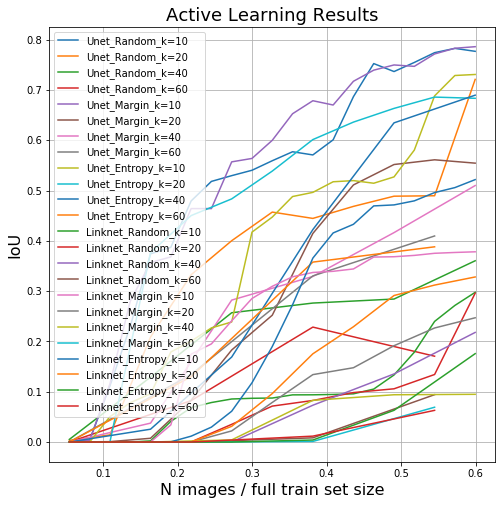

In [7]:
results = pickle_load('results/'+RESULTS_FNAME)

plt.figure(figsize=(8,8))

# choose model
for model_str in MODELS:    
    # choose samples selection function
    for samples_selection_str in SAMPLES_SELECTIONS:        
        # choose number of samples to select for labelling from inference results
        for k in NUM_UNCERTAIN_IMAGES:

            ious = results[model_str][samples_selection_str][str(k)]['IoUs']
            n_train = results[model_str][samples_selection_str][str(k)]['N_train_samples']

            plt.plot(np.array(n_train[1:])/len(X_train_paths), ious[1:], label=model_str+'_'+samples_selection_str+'_k='+str(k))
        
plt.grid()
plt.title('Active Learning Results', fontsize=18)
plt.xlabel('N images / full train set size', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.legend();

### Queery by committee

In [8]:
# unet = SegModel(smp.Unet)
# fpn = SegModel(smp.FPN)
# unet.model = torch.load('./unet_best_model.pth')
# fpn.model = torch.load('./fpn_best_model.pth')

# path = X_test_paths[10]
# img = cv2.imread(path)[...,(2,1,0)]
# pred1 = unet.predict([path]).squeeze().cpu().numpy()
# pred2 = fpn.predict([path]).squeeze().cpu().numpy()

# img_i = 8
# visualize(image=img, mask1=pred1[img_i,...], mask2=pred2[img_i,...])

# from sklearn.metrics import jaccard_similarity_score

# def mean_iou(pred_np1, pred_np2):
#     ious = []
#     for i in range(pred_np1.shape[0]):
#         mask1 = pred_np1[i,...].round().flatten()
#         mask2 = pred_np2[i,...].round().flatten()
#         iou = jaccard_similarity_score(mask1, mask2, normalize=True)
#         ious.append(iou)
#     return np.mean(ious)

# print(f'Mean IoU: {mean_iou(pred1, pred2)}')